In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import numpy as np
import pyproj as pp
import scipy as sp
import transect_analysis as ta
import pdb
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import datetime
import os
from matplotlib.animation import FuncAnimation
%load_ext line_profiler

In [2]:
# Specify start and end coords on coast.
# Choose order so that (transect_axis, coastline_axis) forms a right hand coordinate system
lon0 = 134.5293 
lat0 = -12.4715
coast_lon1 = 133.3290
coast_lat1 = -12.1468

trans_lon0, trans_lat0, trans_lon1, trans_lat1, n_points, n_trans, coast_distances, tran_distances = ta.define_transects(
    lon0, lat0, coast_lon1, coast_lat1, 453361.47128972, spacing=27000
)

# Create basis vectors of new coordinate system
b_lon = trans_lon1[0] - lon0
b_lat = trans_lat1[0] - lat0

In [4]:
try:
    
    P_tran = xr.open_dataset('/g/data/w40/esh563/goulburn_NT/CMORPH_goulburn_201412.nc')

except:

    P = xr.open_mfdataset('/g/data/w40/esh563/goulburn_NT/CMORPH/*.nc')
    P = P.rename({'lat' : 'latitude', 'lon' : 'longitude'})
    P_tran = ta.calc_transects(P, trans_lon0, trans_lat0, trans_lon1, trans_lat1, n_points, n_trans)
    P_tran = P_tran.assign_coords(coastal_axis = coast_distances)\
        .assign_coords(transect_axis = tran_distances)
    P_tran.to_netcdf(path='/g/data/w40/esh563/goulburn_NT/CMORPH_goulburn_201412.nc', mode='w', format='NETCDF4')

In [5]:
# Average over coastal_axis, i.e. over multiple transects
P_tran = P_tran.mean(dim='coastal_axis')

hour = np.arange(0,24,3)

# Create a composite
P_tran_list = [P_tran.where(P_tran['cmorph_precip']['time.hour'] == hour[0]).mean('time', skipna=True)] * 8

hour = np.arange(0,24,3)

for i in range(1,8):
    
    P_tran_list[i] = P_tran.where(P_tran['cmorph_precip']['time.hour'] == hour[i]).mean('time', skipna=True)

P_tran_h = xr.concat(P_tran_list, dim = 'hour_UTC')
P_tran_h = P_tran_h.assign_coords(hour_UTC = hour)

In [8]:
P_tran_h['transect_axis'] = P_tran_h['transect_axis']-40120.484185

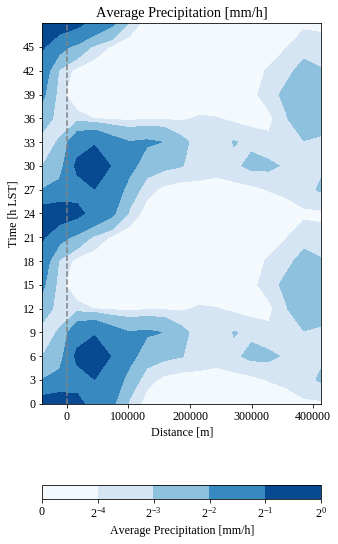

In [11]:
fig, ax = plt.subplots(figsize=(5,10))

# Initialise fonts
rcParams['font.family'] = 'serif'
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'font.size': 12})
rcParams.update({'font.weight': 'normal'})

LST = np.arange(-24,48,3) + 9
z = np.concatenate([np.squeeze(P_tran_h.cmorph_precip.values)]*3, axis=0)

LST = LST[5:22]
z = z[5:22,:]

plt.plot(
    [0, 0], [LST[0], LST[-1]],
    '--', color='grey')

locator = mticker.SymmetricalLogLocator(base=2, linthresh=2**-4)
formatter = mticker.LogFormatterMathtext(base=2)

contour_p = plt.contourf(
    P_tran_h.transect_axis.values,
    LST,
    z, 
    levels = np.array([0, 2**-4, 2**-3, 2**-2, 2**-1, 2**0]),
    cmap = 'Blues',
    norm=colors.SymLogNorm(vmin=0, vmax=1, linthresh=2**-4, linscale=2**-4)
)

plt.title(
    'Average Precipitation [mm/h]'
)
plt.xlabel('Distance [m]')
plt.ylabel('Time [h LST]')

plt.yticks(np.arange(0, 48, step=3))

cbar_w=plt.colorbar(contour_p, orientation='horizontal', ticks=locator, format=formatter)
cbar_w.set_label('Average Precipitation [mm/h]')

plt.savefig('/g/data/w40/esh563/goulburn_NT/CMORPH_201412.png')